# TP 5 - Deep Learning - Optimisation d'un réseau de neurones

In [1]:
try:
    # core libraries
    %tensorflow_version 2.x
    import tensorflow as tf
    import numpy as np
    from sklearn.model_selection import GridSearchCV
    from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
    
    # plot libraries
    import seaborn as sns
    import matplotlib.pyplot as plt
    %matplotlib inline

except Exception:
    print('Tensorflow version 2 not available')

TensorFlow 2.x selected.


## Variables globales

In [0]:
N_CLASSES = 10
INPUT_SHAPE = (28, 28, 1)

TRAIN_SIZE = 5000
TEST_SIZE = 1000

N_EPOCHS = 1
BATCH_SIZE = 64

## 0. Téléchargement des données

In [3]:
def get_data(n_classes):
	# the data, shuffled and split between train and test sets
	(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

	# On transforme les entrée en les vectorisant et on les normalise simplement
	# (on sait que les pixels ont des valeurs entre 0 et 255)
	x_train = x_train.astype('float32') / 255.
	x_test = x_test.astype('float32') / 255.

	# redimensionnement des images pour les injecter dans le réseau
	x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
	x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

	# mettre les labels sous forme discrète
	y_train = tf.keras.utils.to_categorical(y_train, n_classes)
	y_test = tf.keras.utils.to_categorical(y_test, n_classes)

	return x_train, y_train, x_test, y_test

# ---
# download data
# ---

X_train, Y_train, X_test, Y_test = get_data(N_CLASSES)

print(f'original x_train shape {X_train.shape}')
print(f'original y_train shape {Y_train.shape}')
print(f'original x_test shape {X_test.shape}')
print(f'original y_test shape {Y_test.shape}')

# ---
# get a random small part of data
# ---
train_l_idx = list(range(X_train.shape[0]))
test_l_idx = list(range(X_test.shape[0]))

np.random.shuffle(train_l_idx)
np.random.shuffle(test_l_idx)

train_l_idx = train_l_idx[:TRAIN_SIZE]
test_l_idx = test_l_idx[:TEST_SIZE]

x_train, y_train = X_train[train_l_idx], Y_train[train_l_idx]
x_test, y_test = X_test[test_l_idx], Y_test[test_l_idx]

print('\n' * 2)
print(f'selected x_train shape {x_train.shape}')
print(f'selected y_train shape {y_train.shape}')
print(f'selected x_test shape {x_test.shape}')
print(f'selected y_test shape {y_test.shape}')

original x_train shape (60000, 28, 28, 1)
original y_train shape (60000, 10)
original x_test shape (10000, 28, 28, 1)
original y_test shape (10000, 10)



selected x_train shape (5000, 28, 28, 1)
selected y_train shape (5000, 10)
selected x_test shape (1000, 28, 28, 1)
selected y_test shape (1000, 10)


## 1. Comparaisons des algorithmes de gradient 

###  Convnet pour la classification de Mnist

In [0]:
def create_discriminator(optimizer, dropout_rate_1=0.25, dropout_rate_2=0.5):
    model = tf.keras.Sequential()

    # ---
    # convolutional block
    # ---
    model.add(tf.keras.layers.Conv2D(64, input_shape=INPUT_SHAPE,
                                     kernel_size=(3, 3),
                                     activation='relu'))
    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(dropout_rate_1))
    model.add(tf.keras.layers.Flatten())

    # ---
    # classification block
    # ---
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dropout(dropout_rate_2))
    model.add(tf.keras.layers.Dense(N_CLASSES, activation='softmax'))

    # ---
    # compile graph
    # ---
    model.compile(loss='categorical_crossentropy',
                   optimizer=optimizer,
                   metrics=[tf.metrics.categorical_accuracy])
    
    return model

Comparez les routines d'optimisation Adam, Adagrad, Adadelta etc en utiisant dfférents learning rates poru l'apprentissage des modèles défnis ci-dessus

Vous tracerez deux figures, l'une pour l'accuracy, l'autre pour le loss, calculés sur le test set.

Dans chaque figure vous ploitterez la quantité (Accuracy ou Loss) en fonction du learning rate en incluant une courbe par routine d'optimisation.

In [5]:
learning_rates = [1e-1, 1e-2, 1e-3, 1e-4]

optimizers_lr = [
    ('adam', [tf.optimizers.Adam(lr) for lr in learning_rates]),
    ('adagrad', [tf.optimizers.Adagrad(lr) for lr in learning_rates]),
    ('adadelta', [tf.optimizers.Adadelta(lr) for lr in learning_rates]),
    ('rms', [tf.optimizers.RMSprop(lr) for lr in learning_rates])
]

results_lr = [
    ('adam', []),
    ('adagrad', []),
    ('adadelta', []),
    ('rms', [])
]

for idx_opt, optimizer in enumerate(optimizers_lr):
    for opt in optimizer[1]:
        # create and train experience
        disc = create_discriminator(opt)
        disc.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=N_EPOCHS, verbose=1)
        
        # save results
        results_lr[idx_opt][1].append(disc.evaluate(x_test, y_test))

Train on 5000 samples
5000/5000 [==============================] - 14s 3ms/sample - loss: 13.8439 - categorical_accuracy: 0.1046
1000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

* plot results

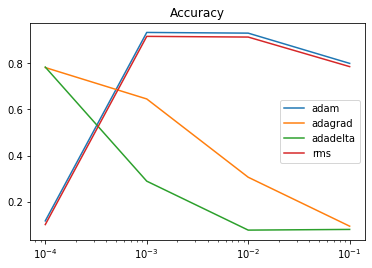

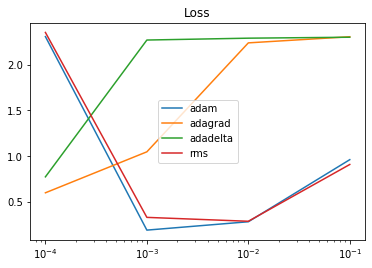

In [7]:
fig = plt.figure()
ax = plt.gca()

for result in results_lr:
    accuracies = []
    for loss, acc in result[1]:
        accuracies.append(acc)
    plt.plot(learning_rates, accuracies[::-1], label=result[0])

ax.set_xscale('log')
plt.legend()
plt.title('Accuracy')
plt.show()


fig = plt.figure()
ax = plt.gca()

for result in results_lr:
    losses = []
    for loss, acc in result[1]:
        losses.append(loss)
    plt.plot(learning_rates, losses[::-1], label=result[0])

ax.set_xscale('log')
plt.legend()
plt.title('Loss')
plt.show()

## 2. Dropout

In [9]:
dropout_rates_1 = [0., 0.25, 0.5]
dropout_rates_2 = [0., 0.25, 0.5]

names = ['adam', 'adagrad', 'adadelta']
optimizers = [tf.optimizers.Adam(), tf.optimizers.Adagrad(), tf.optimizers.Adadelta()]

results_dropout = [[], [], []]

idx_opt = 0
for name, optimizer in zip(names, optimizers):
    for dropout_rate_1 in dropout_rates_1:
        for dropout_rate_2 in dropout_rates_2:
            # create and train experience
            disc = create_discriminator(optimizer, dropout_rate_1, dropout_rate_2)
            disc.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=N_EPOCHS, verbose=1)

            # save results
            results_dropout[idx_opt].append(disc.evaluate(x_test, y_test))
    
    idx_opt += 1

Train on 5000 samples
5000/5000 [==============================] - 14s 3ms/sample - loss: 0.6211 - categorical_accuracy: 0.8128
1000/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

* plot results

In [10]:
for name, result in zip(names, results_dropout):
    print(f'{name} : {result}')

adam : [[0.29382460021972656, 0.928], [0.2265608549118042, 0.943], [0.20145068925619125, 0.94], [0.19148337697982787, 0.951], [0.1997895475924015, 0.942], [0.20071551901102067, 0.941], [0.21129268997907638, 0.943], [0.20645921576023102, 0.944], [0.2158207824230194, 0.936]]
adagrad : [[2.2371458396911623, 0.274], [2.26271635055542, 0.258], [2.261010929107666, 0.284], [2.2758791999816896, 0.185], [2.254311351776123, 0.207], [2.2894680137634276, 0.176], [2.2633290538787842, 0.165], [2.2894265785217285, 0.104], [2.2813348693847657, 0.194]]
adadelta : [[2.302405679702759, 0.133], [2.2946860904693605, 0.094], [2.296278652191162, 0.131], [2.294615261077881, 0.1], [2.2989112243652343, 0.071], [2.303048553466797, 0.116], [2.298247486114502, 0.103], [2.3025151329040527, 0.064], [2.293130760192871, 0.069]]


* Meilleur résultat pour `optimizer='adam'` avec `dropout_1=0.25` et `dropout_2=0.` 

## 3. Batch Normalization

1. Rajoutez une couche de BatchNormalization et expliquez le nombre de paramètres trainable et not trainable


2. Calculez les statistiques sur les activations moyennes (et les variances)  dans les différentes couches. Vous devez apprendre un réseau avec BN et un autre sans, puis faire passer les données d'apprentissage dans le réseau et extraire les prédictions sur les différentes couches cachées, puis afficher les valeurs moyennes d'activation sur les différentes couches.

NB: Le comportement de la couche de BN est plus visible avec des réseaux profonds non convolutionnels


In [0]:
def create_dnn(batch_normalization, optimizer='adam'):
    model = tf.keras.Sequential()

    # ---
    # dense block
    # ---
    model.add(tf.keras.layers.Flatten(input_shape=INPUT_SHAPE))
    model.add(tf.keras.layers.Dense(512, activation='relu'))
    if batch_normalization :
        model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dense(1024, activation='relu'))
    if batch_normalization :
        model.add(tf.keras.layers.BatchNormalization())

    # ---
    # prediction block
    # ---
    model.add(tf.keras.layers.Dense(N_CLASSES, activation='softmax'))

    # ---
    # graph compilation
    # ---
    model.compile(optimizer=optimizer,
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])
    
    return model

In [18]:
has_bn_list = [False, True]
results_bn = {}

for has_bn in has_bn_list:
    # create and train experience
    disc = create_dnn(has_bn)
    disc.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=10, verbose=1)

    # save results
    results_bn[str(has_bn)] = disc.evaluate(x_test, y_test)

    # print model architecture
    disc.summary()

Train on 5000 samples
Epoch 1/10
5000/5000 [==============================] - 2s 316us/sample - loss: 0.5830 - accuracy: 0.8258
Epoch 2/10
5000/5000 [==============================] - 1s 245us/sample - loss: 0.1985 - accuracy: 0.9388
Epoch 3/10
5000/5000 [==============================] - 1s 256us/sample - loss: 0.1109 - accuracy: 0.9668
Epoch 4/10
5000/5000 [==============================] - 1s 273us/sample - loss: 0.0703 - accuracy: 0.9790
Epoch 5/10
5000/5000 [==============================] - 1s 239us/sample - loss: 0.0438 - accuracy: 0.9878
Epoch 6/10
5000/5000 [==============================] - 1s 242us/sample - loss: 0.0267 - accuracy: 0.9920
Epoch 7/10
5000/5000 [==============================] - 1s 261us/sample - loss: 0.0297 - accuracy: 0.9904
Epoch 8/10
5000/5000 [==============================] - 1s 254us/sample - loss: 0.0092 - accuracy: 0.9984
Epoch 9/10
5000/5000 [==============================] - 1s 239us/sample - loss: 0.0026 - accuracy: 0.9994
Epoch 10/10
5000/5000 [=

* plot results

In [15]:
print(results_bn['False'])
print(results_bn['True'])

[0.2639517448656261, 0.952]
[0.37186478880047796, 0.941]


## Optimisation des hyperparamètres

Quel que soit le problème, quelles que soient vos données, il existe un certain nombre d'hyper paramètres à régler pour apprndre un bon modèle (architceture du modèle, paramètres de l'algorithme d'optimisation etc).

C'est l'objet du gridsearch, qui peut être exhaustif ou pas.

Avant de vous lancer dans un gridsearch faites une estumation du temps que cela prendra.

### Gridsearch


En utilisant un embedding des modèles dans sklearn et le gridsearchCV de sklearn

In [0]:
def create_discri_BN(optimizer='rmsprop', nb_filters1= 64,  nb_filters2= 32, fact = 'relu', nb_hid = 128, do_rate= 0.5, BN=False):
    d_input = Input(shape=(28, 28, 1) ,name="input")
    x = Conv2D(nb_filters1, kernel_size=(3, 3), activation='relu') (d_input)
    x = Conv2D(nb_filters2, (3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    if BN :
      x = BatchNormalization()(x)
    x = Flatten()(x)
    x = Dense(nb_hid)(x)
    x = Activation(fact)(x)
    x = Dropout(do_rate)(x)
    d_prediction = Dense(nb_classes, activation='softmax')(x)
    discriminatorC = Model(input = d_input, output = d_prediction)
    discriminatorC.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=["accuracy"])
    return discriminatorC
  

In [0]:

model = KerasClassifier(build_fn=create_discri_BN)

optimizers = ['rmsprop']
epochs = [10]
V_nb_hid = [64, 128]
DO_rate=[0, 0.25, 0.5]

param_grid = dict(optimizer=optimizers,  nb_hid =V_nb_hid, do_rate= DO_rate)

print (param_grid)

grid = GridSearchCV(estimator=model, param_grid=param_grid)
grid_result = grid.fit(X_train, Y_train, epochs = 1, verbose=2)
# summarize results                                                                                                                                           
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


Si vous utilisez un cluster de calcul, il est souvent plus simple 
- De lancer un job par jeu d'hyperparametres
=> Boucles énumérant toutes les conbinaisons : Un job lancé à chaque fois



### Optimisation Hyperas 
Cf. https://conference.scipy.org/proceedings/scipy2013/pdfs/bergstra_hyperopt.pdf
Stratégie d'exploration partielle et informée de l'espace de recherche 

La méthode explore une partie de l'espace de recherche en construisant au fur et à mesure une mesure d'intérêt des différets paramètres à faire varier (voir l'article cité cidessus).

Nb: Pour utiliser hyperas avec google colab votre notebook doit etre sauvegardé sur google colab et vous devez spécifier son chemin (voir cellule suivante).


In [0]:
!pip install hyperas
!pip install hyperopt

from hyperopt import Trials, STATUS_OK, tpe
from keras.datasets import mnist
from keras.layers.core import Dense, Dropout, Activation
from keras.models import Sequential
from keras.utils import np_utils

from hyperas import optim
from hyperas.distributions import choice, uniform


def create_model(X_train, Y_train, X_test, Y_test):
   
    """Model providing function:

    Create Keras model with double curly brackets dropped-in as needed.
    Return value has to be a valid python dictionary with two customary keys:
        - loss: Specify a numeric evaluation metric to be minimized
        - status: Just use STATUS_OK and see hyperopt documentation if not feasible
    The last one is optional, though recommended, namely:
        - model: specify the model just created so that we can later use it again."""
 

    model = Sequential()
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout({{uniform(0, 1)}}))
    model.add(Flatten())
    model.add(Dense({{choice([64, 128, 256])}}))
    model.add(Activation({{choice(['relu', 'sigmoid'])}}))
    model.add(Dropout({{uniform(0, 1)}}))

    # If we choose 'four', add an additional fourth layer

    model.add(Dense(10))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],
                  optimizer={{choice(['rmsprop', 'adam', 'sgd'])}})

    model.fit(X_train, Y_train,
              batch_size={{choice([64, 128])}},
              epochs=1,
              verbose=2,
              validation_data=(X_test, Y_test))
    score, acc = model.evaluate(X_test, Y_test, verbose=0)
    print('Test accuracy:', acc)
    return {'loss': -acc, 'status': STATUS_OK, 'model': model}


init_datas()  

In [0]:
best_run, best_model = optim.minimize(model=create_model,
                                      data=init_datas2,
                                      algo=tpe.suggest,
                                      max_evals=5,
                                      trials=Trials(), 
                                      notebook_name='TP4_DL_2018_OptimDNN_Etus')
X_train, Y_train, X_test, Y_test = init_datas2()
print("Evalutation of best performing model:")
print(best_model.evaluate(X_test, Y_test))
print("Best performing model chosen hyper-parameters:")
print(best_run)

## Conclusion : Régularisation et taille de l'ensemble d'apprentissage

- Trouver la meilleure stratégie d'apprentissage pour une architcteure neuronale donnée, sur les données MNIST et pour des jeux de données limités. Vous utiliserez plusieurs tirages random pour chaque taille et calculerez des résultats moyennés. Vous utiliserez deux tailles de base d'apprentissage.
    - 1000 données d'apprentissage en tout (environ 100 par classe)
    - 5000 données d'apprentissage en tout (environ 500)

- Vous discuterez suite à vos résultats de l'intérêt de la régularisation dans le cas de données limitées et de l'intérêt des différentes techniques de regularisation (dropout, pénalisation L1, L2)
